![algorithm overview](https://maartengr.github.io/BERTopic/algorithm/modularity.svg)

In [1]:
import pandas as pd
import umap
import hdbscan
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# as a proof of concept use unprocessed data, as embeddings should handle them
df = pd.read_csv('../../data/arxiv.csv', sep=';')
data = df['Summary'].tolist()

In [3]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar=True)

Batches:   0%|          | 0/1081 [00:00<?, ?it/s]

In [4]:
# get a smaller umap representation to reduce dimensionality
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

In [5]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

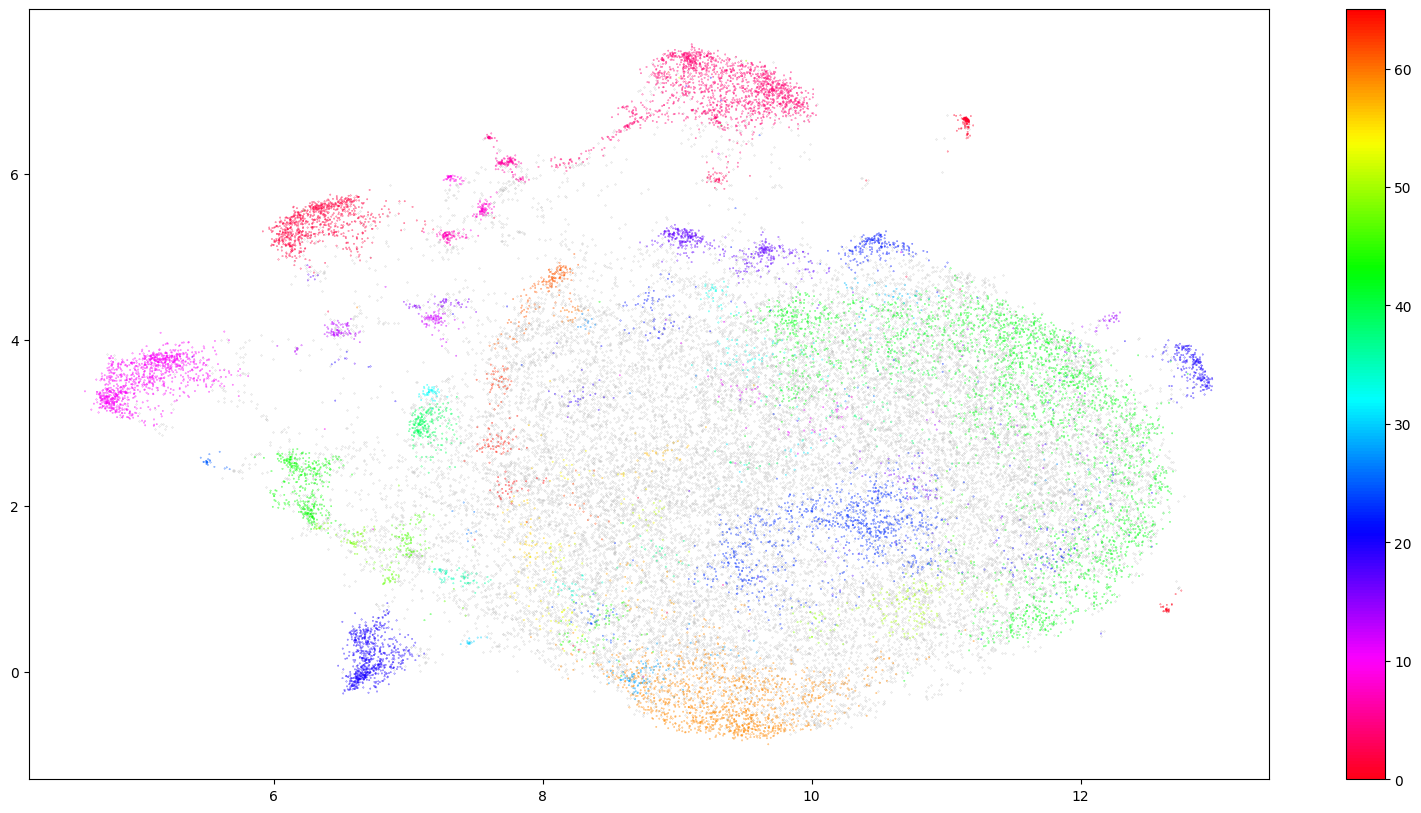

In [6]:
# Prepare data for visualization
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [19]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [20]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [21]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,21413
43,42,2663
5,4,1584
60,59,1244
11,10,1059
21,20,937
24,23,933
3,2,821
18,17,420
44,43,376


In [22]:
for i in range(10):
    topic = topic_sizes.iloc[i].Topic
    print(f"Topic {topic}")
    words = [i[0] for i in  top_n_words[topic][:10]]
    print(words)

Topic -1
['ai', 'language', 'knowledge', 'tasks', 'problem', 'new', 'large', 'systems', 'training', 'algorithm']
Topic 42
['domain', 'training', 'datasets', 'state', 'method', 'propose', 'existing', 'policy', 'methods', 'task']
Topic 4
['medical', 'clinical', 'patient', 'patients', 'healthcare', 'health', 'disease', 'diagnosis', 'cancer', 'segmentation']
Topic 59
['logic', 'set', 'semantics', 'algorithm', 'programs', 'belief', 'probabilistic', 'theory', 'decision', 'problem']
Topic 10
['robot', 'robots', 'robotic', 'robotics', 'planning', 'environments', 'navigation', 'manipulation', 'environment', 'human']
Topic 20
['llms', 'language', 'reasoning', 'evaluation', 'theory', 'task', 'paper', 'analysis', 'different', 'dataset']
Topic 23
['graph', 'graphs', 'gnns', 'node', 'nodes', 'gnn', 'networks', 'neural', 'structure', 'edges']
Topic 2
['traffic', 'driving', 'vehicle', 'urban', 'vehicles', 'road', 'autonomous', 'transportation', 'prediction', 'city']
Topic 17
['video', '3d', 'videos', 

In [23]:
for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); 
topic_sizes.head(10)

,Topic,Size
0,-1,21638
31,30,2747
4,3,1584
42,41,1271
9,8,1059
17,16,937
20,19,933
2,1,821
16,15,420
32,31,400


In [24]:
# get the top 20 words for each of the top 10 topics
for i in range(10):
    topic = topic_sizes.iloc[i].Topic
    print(f"Topic {topic}")
    words = [i[0] for i in  top_n_words[topic][:10]]
    print(words)

Topic -1
['ai', 'language', 'knowledge', 'tasks', 'problem', 'large', 'new', 'systems', 'training', 'llms']
Topic 30
['domain', 'training', 'datasets', 'state', 'policy', 'propose', 'method', 'methods', 'existing', 'rl']
Topic 3
['medical', 'clinical', 'patient', 'patients', 'healthcare', 'health', 'disease', 'diagnosis', 'cancer', 'segmentation']
Topic 41
['logic', 'set', 'semantics', 'algorithm', 'programs', 'belief', 'theory', 'probabilistic', 'rules', 'decision']
Topic 8
['robot', 'robots', 'robotic', 'robotics', 'planning', 'environments', 'navigation', 'manipulation', 'environment', 'human']
Topic 16
['llms', 'language', 'reasoning', 'evaluation', 'theory', 'task', 'paper', 'analysis', 'different', 'dataset']
Topic 19
['graph', 'graphs', 'gnns', 'node', 'nodes', 'gnn', 'networks', 'neural', 'structure', 'edges']
Topic 1
['traffic', 'driving', 'vehicle', 'urban', 'vehicles', 'road', 'autonomous', 'transportation', 'prediction', 'city']
Topic 15
['video', '3d', 'videos', 'frames', 